# Simple building model for heating demand estimation

Lorant Sztranyovszky
30.11.2023


  Content:

**- Introduction**

**- Thermal model**

**- Implementation**

**- Results and discussion**


## Introduction

This work models the thermal behavior of a small building. The model provides insight to the heating demand, specifically, the temporal distribution of the required heating power that the HVAC system has to supply. The model simulates one complete year and uses meterolocical data including outdoor temperature and irradiance to derive the heat demand profile. The temperature at which this heat must be supplied is also a quantity of interest for an exergetic consideration.

#### Building geometry
The geometry has been greatly simplified, the building is represented by a cube with half of one side being covered by window, the other surfaces including the roof are modelled as walls, with the floor having its own kind of structure. This simplification helps to obtain the viewing factors in a simple way. The geometry is shown on figure 1. 

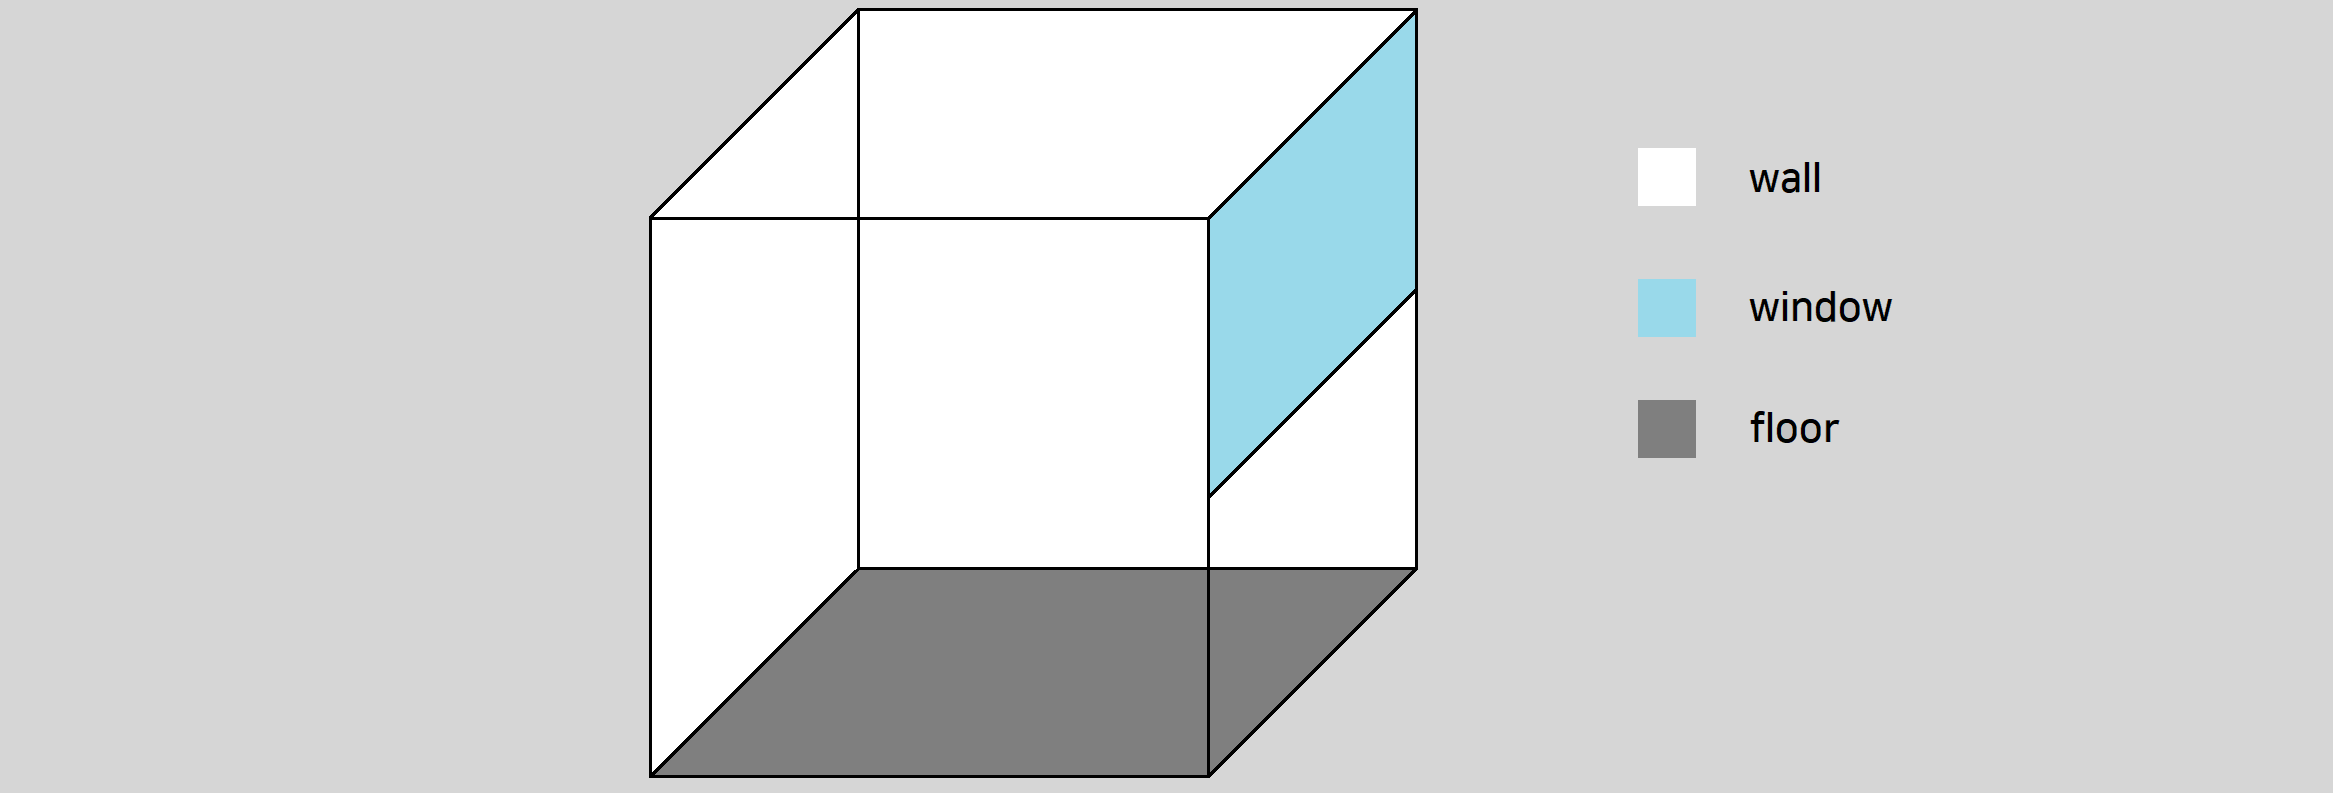
> Figure 1. Geometric representation 

The building walls consist of one layer of concrete and one layer of insulation (on the outside). The representation of the floor is a bit more complex, which has to do with the focus of this model being on the heating system. The heating is assumed to be provided by underfloor heating. The floor is assumed to consist of one (top) layer of concrete, insulation, and another thick layer of concrete below as the foundation of the building. The heating power is fed to between the insulation and the top concrete layer. In order to represent the diffusion of heat in the thermally active layer of ground below the building, this has been added as an additional layer.

#### Assumptions
Regarding the location, it is assumed that there building is located at a completely unshaded area. This is important for the purpose of solar radiation, as no correction must be applied to direct irraditance and radiation reflected or emmitted by nearby objects can be neglected. The ventillation is assumed to include no regeneration. It is further assumed that the building is used as a single family house with constant presence.

## Thermal model

The simplified thermal model of the building can be seen on figure 2. (explanation below)
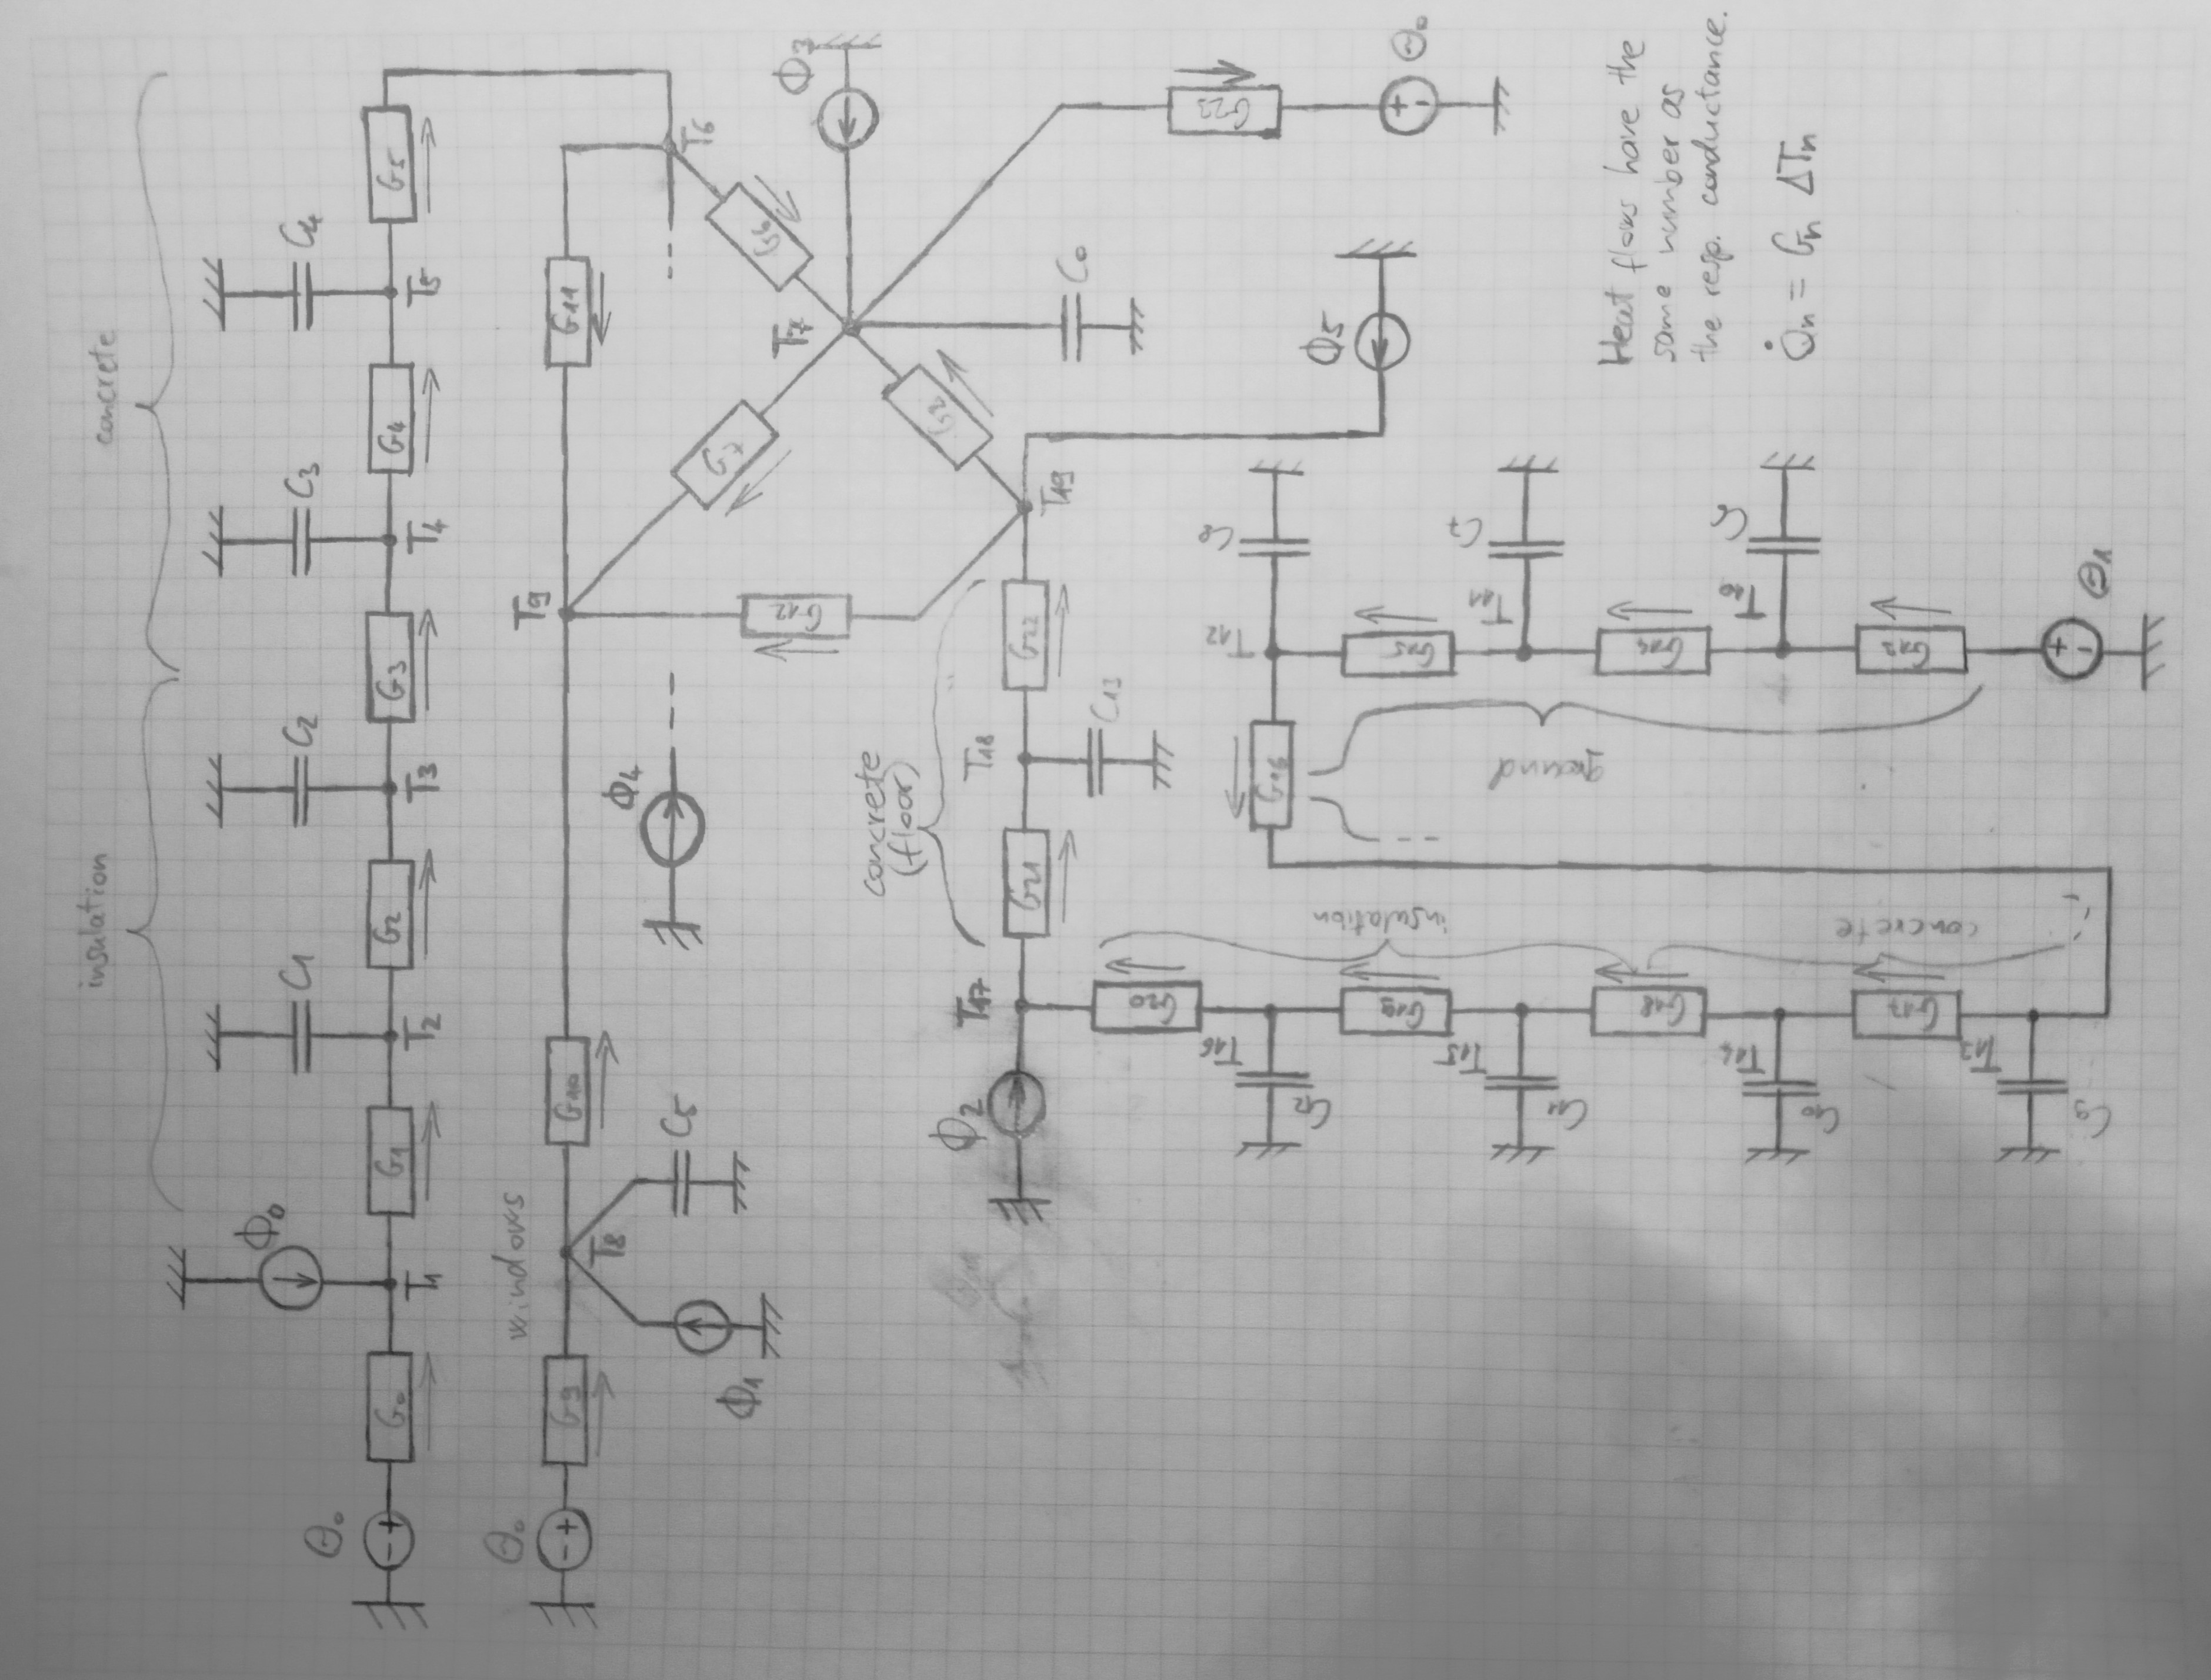
> Figure 2. Thermal model 

#### Inputs
The inputs include the indoor setpoint temperature and two time series for ambient temperature and solar irradiance. The temperature data has been obtained from Meteostat for the year 2019, the location is 47.175, 8.109 (Sursee, Switzerland). 

The irradiance profile has been created with the following method: Using the API of PVGIS, hourly location-specific irradiance data can be obtained for a surface with arbitrary inclination and azimuth angles. (The data includes direct and diffuse components.) This data was taken for five surfaces: four vertical ones facing north, east, south and west and one horizontal surface. The average of these five pfofiles has been used in the model for all surfaces. This might seem like too much of a simplification but it can be justified if one assumes the windows to be distributed evenly on all sides of the building. Using this aproach, there is no neeed to use separate irradiance data for each side of the building.

The inputs are represented by temperature and (radiative) heat flow sources in the model. The outdoor temperature interacts with the outer surface of the walls and windows by convective heat transfer, and with the indoor air by advection (ventillation). The ground tempreature is also a temperature source (constant value) at the bottom of the thermally active ground layer as a boundary condition for diffusion.The radiative heat sources include short-wave radiation absorbed by the outer surface of the wall, the bulk of the window and the radiation transmitted throught the window will be absorbed on the indoor surfaces.

#### Spacial discretization
The walls has been discretized by four finite volumes, two for the concrete and insulation each. The windows are considered as a single volume. The discretization of the floor includes one layer for the concrete on top, two layers for the iinsulation and foundation each, and three layers for the thermally active ground underneath. There are three temperature nodes in the inside of the building (inner surface of wall, window and floor) which don't have capacities. These are relevant for the convective and radiative heat transfer. The indoor air is considered as a single volume, natural convection is not resolved, approximate convection coefficients are used instead.

#### Mathematical description
The conductances are calculated from material and process properties as follows:

Conduction:  $G_{cond} = \frac{\lambda}{d}S$      where ${\lambda}$ is the thermal conductivity, d is the layer thickness and S is the surface area

Convection:  $G_{conv} = {\alpha}*S$       where ${\alpha}$ is the (empirical) convection coefficient

Radiation:  $G_{rad, n} = 4 \sigma \bar{T}^3 \frac{\varepsilon_n}{1 - \varepsilon_n} S_n$    where $\bar{T}$ is the mean temperature of the surfaces (linearization), ${\varepsilon_n}$ is the emmissivity and $\sigma$ is the Stefan-Boltzmann consntant

Advection: $G_{adv} = \rho_a c_p \frac{\mathrm{ACH}}{3600} V_a$    where $\mathrm{ACH}$ is the air exchanges per hour , $V_a$ is the indoor air volume, $\rho_a$ and $c_p$ are the density and heat capacity of the air respectively.

Capacities are calculated for each finite volume as:

$$C_n = \rho_n cp_n d_n S_n$$

The system of algebraic-differential equation are set up:
$$\left\{\begin{array}{ll}
C \dot{T} = -(A^T G A) T + A^T G b + f\\ 
Q = G (-A T + b)
\end{array}\right.$$

   Where b and f represent the temperature and heat flow source vectors respectively, and A is the connectivity matrix.

This system is subsequently transformed to the state-space representation
$$\left\{\begin{array}{rr}
\dot{T}_s=A_s T_s + B_s u\\ 
y = C_s T_s + D_s u
\end{array}\right.$$

Thi system is then solved by implicit time integration. The implicit method was chosen so that large time steps don't make the model unstable. Since the intention is to simulate a whole year, having small time steps would be quite computationally expensive.

## Implementation

The geometry parameters specify the dimensions

In [1]:
import array
import numpy as np
import pandas as pd
import dm4bem

# Parameters-----------------------------------------------------
# Geometry
d_wall_con = 0.2  # Wall concrete thickness
d_wall_ins = 0.2  # Wall insulation thickness
d_win = 0.04  # Window thickness
d_gro = 5  # Thermally active ground thickness
d_flo_con = 0.12  # Floor concrete thickness
d_flo_ins = 0.25  # Floor insulation thickness
d_fou = 0.4  # foundation thickness
S_wall = 216  # wall surface area
S_win = 24  # window surface area
S_flo = 64  # floor surface area
F_wall_win = 0.08  # viewing angle walls to windows
F_wall_flo = 0.237  # viewing angle walls to floor
F_win_wall = 0.7  # viewing angle windows to walls
F_win_flo = 0.25  # viewing angle windows to floor
F_flo_wall = 0.8  # viewing angle floor to walls
V_air = 384  # volume of indoor air

Then the material properties are specified. The transmittance of the window for short wave is set intentionally lower than physically reasonable to account for the fact that window surfaces are rarely unobstructed (e.g. curtains).

In [2]:
# Materials
la_con = 1.4  # concrete thermal conductivity
la_ins = 0.035  # insulation thermal conductivity
la_gla = 0.05  # glass thermal conductivity
la_gro = 2.5  # ground thermal conductivity
cp_con = 880  # concrete heat capacity
cp_ins = 1210  # insulation heat capacity
cp_gla = 1210  # glass heat capacity
cp_gro = 880  # ground heat capacity
cp_air = 1000  # air heat capacity
rho_con = 2300  # concrete density
rho_ins = 55  # insulation density
rho_gla = 2500  # glass density
rho_gro = 1700  # ground density
rho_air = 1.2  # air density
eps_wall_vis = 0.6  # wall short wave emmissivity
eps_wall_ir = 0.6  # wall long wave emmissivity
eps_win_ir = 0.9  # window long wave emmissivity
eps_win_vis = 0.1  # window short wave emmissivity
eps_flo_vis = 0.7  # floor short wave emmissivity
tra_win_vis = 0.4  # window short wave transmittance

Then the remaining paramters

In [3]:
# Others
con_out = 25  # outdoor convection coefficient
con_in_wall = 7.7  # indoor convection coefficient for walls and windows
con_in_flo = 10  # indoor convection coefficient for floor
ACH = 0.25  # air changes per hour
T_mean = 296  # estimated mean temperature of indoor surfaces in [K]
sig = 5.67E-8  # Stefan-Boltzmann constant
T_gro = 10  # ground temperature (assumed constant)
Q_ind = 300  # indoor heat source (assumed constant)
T_set = 21 # indoor setpoint temperature (assumed constant)

Conductances and capacities are calculated

In [4]:
# Network elements ---------------------------------------------------
# Conductances
G0 = S_wall*con_out
G1 = S_wall*la_ins/(d_wall_ins*0.25)
G2 = S_wall*la_ins/(d_wall_ins*0.5)
G3 = 1/(((d_wall_ins*0.25)/(S_wall*la_ins))+((d_wall_con*0.25)/(S_wall*la_con)))
G4 = S_wall*la_con/(d_wall_con*0.5)
G5 = S_wall*la_con/(d_wall_con*0.25)
G6 = S_wall*con_in_wall
G7 = S_win*con_in_wall
G8 = S_flo*con_in_flo
G9 = 1/((1/(S_win*con_out))+((d_win*0.5)/(la_gla*S_win)))
G10 = la_gla*S_win/(d_win*0.5)
G11 = 4*sig*(T_mean**3)*F_wall_win*S_wall
G12 = 4*sig*(T_mean**3)*F_win_flo*S_win
G13 = S_flo*la_gro/(d_gro/6)
G14 = S_flo*la_gro/(d_gro/3)
G15 = S_flo*la_gro/(d_gro/3)
G16 = 1/(((d_gro/6)/(S_flo*la_gro))+((d_fou*0.25)/(S_flo*la_con)))
G17 = S_flo*la_con/(d_fou*0.5)
G18 = 1/(((d_fou*0.25)/(S_flo*la_con))+((d_flo_ins*0.25)/(S_flo*la_ins)))
G19 = S_flo*la_ins/(d_flo_ins*0.5)
G20 = S_flo*la_ins/(d_flo_ins*0.25)
G21 = S_flo*la_con/(d_flo_con*0.5)
G22 = S_flo*la_con/(d_flo_con*0.5)
G23 = rho_air*cp_air*((ACH*V_air)/3600)

# Capacities
C0 = V_air*rho_air*cp_air
C1 = S_wall*d_wall_ins*0.5*rho_ins*cp_ins
C2 = S_wall*d_wall_ins*0.5*rho_ins*cp_ins
C3 = S_wall*d_wall_con*0.5*rho_con*cp_con
C4 = S_wall*d_wall_con*0.5*rho_con*cp_con
C5 = S_win*d_win*rho_gla*cp_gla
C6 = S_flo*d_gro*rho_gro*cp_gro/3
C7 = S_flo*d_gro*rho_gro*cp_gro/3
C8 = S_flo*d_gro*rho_gro*cp_gro/3
C9 = S_flo*d_fou*0.5*rho_con*cp_con
C10 = S_flo*d_fou*0.5*rho_con*cp_con
C11 = S_flo*d_flo_ins*0.5*rho_ins*cp_ins
C12 = S_flo*d_flo_ins*0.5*rho_ins*cp_ins
C13 = S_flo*d_flo_con*rho_con*cp_con

And the time series are imported

In [5]:
T_amb = np.loadtxt('Tamb.txt')  # outdoor temperature array
Irrad = np.loadtxt('Irrad_avg.txt')  # short wave irradiance array

This is followed by the assembly of the thermal circuit. (The connectivity matrix is imported from a separate csv file.)

In [6]:
θ = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10',
     'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19']
q = ['Q0', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
     'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23']

# Connectivity matrix
A = pd.read_csv('A_mat.csv', header=None) 
A = A.to_numpy()
A = pd.DataFrame(A, index=q, columns=θ)
# Conductance matrix
G = np.array(np.hstack([G0, G1, G2, G3, G4, G5, G6, G7, G8, G9, G10, G11, G12,
                       G13, G14, G15, G16, G17, G18, G19, G20, G21, G22, G23]))
G = pd.DataFrame(G, index=q)
# Capacity vector
C = np.array(np.hstack([0, C1, C2, C3, C4, 0, C0, C5, 0, C6, C7, C8, C9, C10, 
                        C11, C12, 0, C13, 0]))
C = pd.DataFrame(C, index=θ)
# Temperature source vector
b = pd.Series(['T_amb', 0, 0, 0, 0, 0, 0, 0, 0, 'T_amb', 0, 0, 0, 'T_gro', 0,
               0, 0, 0, 0, 0, 0, 0, 0, 'T_amb'], index=q)
# Heat source vector
f = pd.Series(['Q_wall_out', 0, 0, 0, 0, 'Q_wall_in', 'Q_ind', 'Q_win_out', 0,
               0, 0, 0, 0, 0, 0, 0, 'Q_heat', 0, 'Q_flo'], index=θ)
# Output vector
y = np.zeros(19)
y[[6]] = 1
y = pd.Series(y, index=θ)

TC = {"A": A,
      "G": G,
      "C": C,
      "b": b,
      "f": f,
      "y": y}

The model is then transformed in state-space represenattion

In [7]:
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

The time step is specified and the time-series are resampled to match.

In [8]:
dt = 900 # time step [s]

tim = np.loadtxt('time.txt', dtype=str, delimiter=';')
tim = pd.to_datetime(tim, format='%Y-%m-%d %H:%M:%S')
Irrad = pd.DataFrame(Irrad, index=tim)
Irrad = Irrad.resample(str(dt) + 'S').interpolate(method='linear')
Irrad = Irrad[0].values
T_amb = pd.DataFrame(T_amb, index=tim)
T_amb = T_amb.resample(str(dt) + 'S').interpolate(method='linear')
T_amb = T_amb[0].values

Finally, the heat sources are calculated for each time step. Note that the heat supplied by HVAC is only filled up with zeros for now, these values will be specified during time integration for each time step based on the deviation of the indoor air temperature from the setpoint (P controller).

In [9]:
Q_wall_out = S_wall*eps_wall_vis*Irrad
Q_wall_in = S_win*F_win_wall*Irrad*tra_win_vis*eps_wall_vis
Q_win_out = S_win*Irrad*eps_win_vis
Q_flo = S_win*F_win_flo*Irrad*tra_win_vis*eps_flo_vis
Q_heat = np.zeros(int(8759*(3600/dt)+1)) # Heat supplied by HVAC

input_data_set = pd.DataFrame({'T_amb': T_amb, 'T_gro': T_gro, 'Q_heat': Q_heat, 'Q_ind': Q_ind,
  'Q_wall_out': Q_wall_out, 'Q_wall_in': Q_wall_in, 'Q_win_out': Q_win_out, 'Q_flo': Q_flo})
u = dm4bem.inputs_in_time(us, input_data_set)

The model is now set up, the time integration can take place. As simplification, all nodes of the model start at the same temperature T0. The thermal power to be supplied is capculated at the beginning of each time step and is bound to between 0 and 4 kW. The controller gain is 6000 W/K

In [10]:
# Initial conditions
T0 = 15
T_imp = pd.DataFrame(index=u.index)
T_imp[As.columns] = T0
T_imp.iloc[0, 7], T_imp.iloc[0, 8], T_imp.iloc[0, 9] = T_gro, T_gro, T_gro
I = np.eye(As.shape[0])     # identity matrix
# Time integration loop
for k in range(u.shape[0] - 1):
    u.iloc[k,8]=max(min((T_set-T_imp.iloc[k,4])*6000,4000),0)
    T_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (T_imp.iloc[k] + dt * Bs @ u.iloc[k])

The first output is the indoor air temperature. This hould be close to the setpoint, except if cooling would be required. (Cooling is not implemented in this model.) The two further outputs are the evolution of the heating demand and the floor's temperature (at which thermal power must be supplied). The last command prints the specific yearly heat demand of the building in   $\frac{kWh}{{m}^2a}$

In [11]:
T_ind=T_imp.iloc[:,4]
Q_heat=u.iloc[:,8]
T_heat=T_imp.iloc[:,13]
print(sum(Q_heat)*(dt/3600)/(1000*S_flo))

64.89888877787212


## Results and discussion

The simulation has yielded an specific annual heat demand of **64.95 kWh/m2**. For reference, Swiss regulations prescribe a maximum heating demand of 40 kWh/m2 for new residential buildings. The calculated value is somewhat higher, despite the thick insulation. The difference can of course arise from the inaccuracy of the model but also the high setpoint temperature of 21 degrees. Figure 3 shows the temporal distribution of the heating demand.
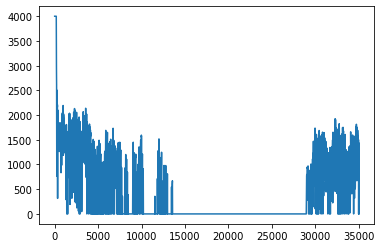
> Figure 3. Heat demand profile over the year

As expected, most of the demand is concentrated in the winter months. It can also be seen that the peak heating demand is only around 2200 W (neglecting the transient in the beginning). 

Tanking a closer look at a shorter period, it can be seen how the heat demand changes in response to ambient temperature and solar irradiance. Figure 4 shows the a period of 20 days in February.

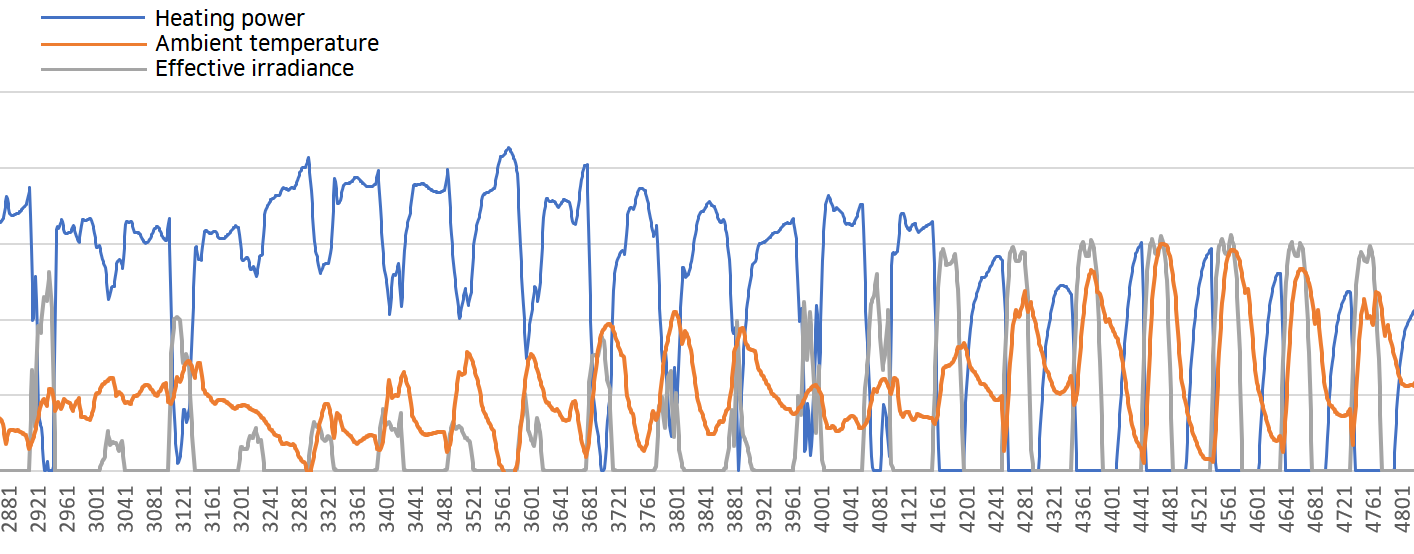
> Figure 4. Heat demand profile for the first 20 days of February, with ambient temperature and effective irradiance

The relationship is as expected, irradiance has an effect to the heating demand both directly and indirectly through the ambient temperature. In periods with sufficient irradiance, the heating is not needed at all during the day. Towards the end of the plotted period one can also observe a slight delay when the irradiance drops at the end of the day, the heating system only starts supplying energy later due to the thermal inertia of the building.

Interestingly, the temperature of the floor remains below 25°C for the whole heating season. (It goes above during summer because cooling is not implemented.)
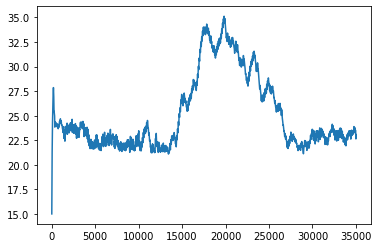
> Figure 5. Floor temperature over the year

The simulation was repeated with a setpoint temperature of 19 degrees. This yielded an annual heat demand of **49.13 kWh/m2**, significantly lower than before. This highlights the variation in heating simulations based on how we chose this value.

Lastly, the irradiance component was switched off to see how much neglecting it would impact the result. The heat demand amounted to **96.33 kWh/m2**, which shows that one should not neglect this contribution.